In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform
from cmdstanpy import CmdStanModel

Se definen rutas de interés para el notebook, y configuraciones generales de figuras

In [2]:
# Paths absolutos
__file__ = '00_radon.ipynb'
CURRENT = os.path.dirname(os.path.abspath(__file__))
ROOT = os.path.dirname(CURRENT)

# Configuración general de gráficas
chart_specs = {
    'title':14
    ,'label':12
    ,'text':10
    ,'colors':{'red':'#AB2400', 'grey':'#D5D5D5'}
}

Se verifica que la carga de datos sea correcta

In [3]:
# Carga de datos procesados
radon = pd.read_csv(os.path.join(ROOT, 'datos/procesado/radon.csv'))
radon.head()

,state,floor,county,log_radon,log_uranium
0,AZ,1,APACHE,-1.203973,0.817297
1,AZ,9,APACHE,-0.510826,0.817297
2,AZ,1,APACHE,-0.693147,0.817297
3,AZ,1,APACHE,-0.510826,0.817297
4,AZ,1,APACHE,-1.203973,0.817297


¿Cuál es la proporción de registros por tipo de piso?

In [4]:
sr_ = (
    radon
    .query("floor in [0,1]")
    .floor
    .value_counts()
)

sr_ / sr_.sum()

floor
0    0.684144
1    0.315856
Name: count, dtype: float64

# Análisis Exploratorio de Datos 

¿Cuántos datos existe por cada estado de la base?

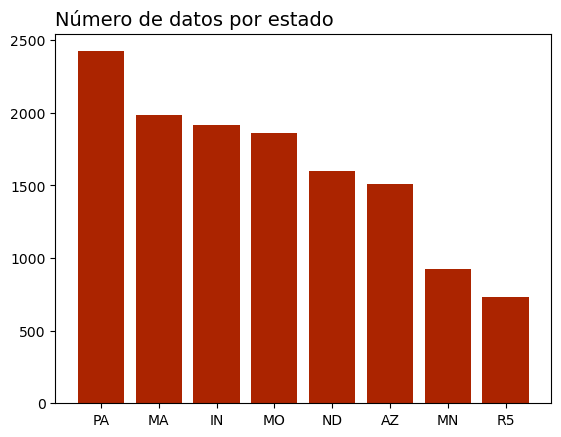

In [5]:
# Datos
df_ = (
    radon
    .state
    .value_counts()
)

# Figura
plt.bar(
    x=df_.index
    ,height=df_.values
    ,color=chart_specs['colors']['red'])

# Anotaciones y estilo
plt.title('Número de datos por estado', fontsize=chart_specs['title'], loc='left')
plt.savefig('../images/datos_p_edo.png')

plt.show()

¿Cuántos datos hay por tipo de piso?

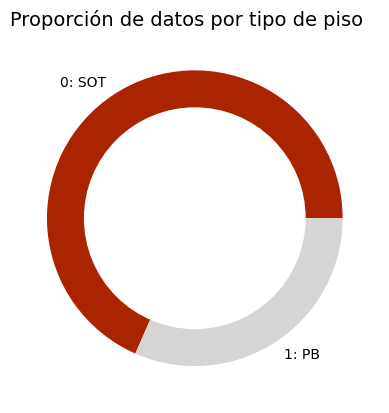

In [6]:
# Datos
df_ = (
    radon
    .query("floor in [0,1]")
    .floor
    .value_counts()
)

# Figura
plt.pie(
    df_.values
    ,colors=[chart_specs['colors']['red'], chart_specs['colors']['grey']]
    ,labels=['0: SOT', '1: PB']
    ,pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Anotaciones y estilo
plt.title('Proporción de datos por tipo de piso', fontsize=chart_specs['title'], loc='left')
plt.savefig('../images/datos_p_piso.png')

plt.show()

Proporción de sótanos por estado

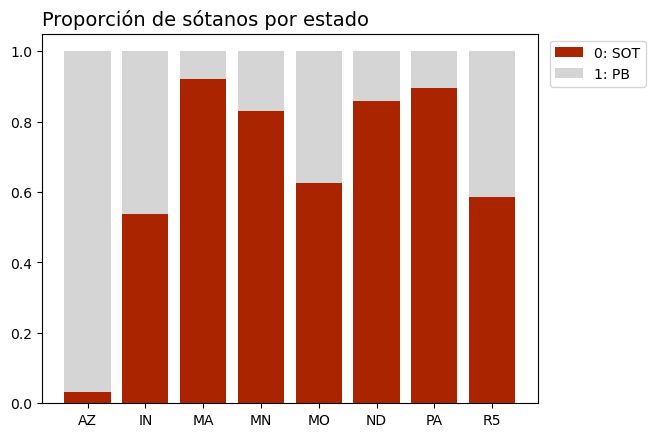

In [7]:
df_ = (
    radon
    .query("floor in [0,1]")
    .pivot_table(
        values='county'
        ,index='state'
        ,columns='floor'
        ,aggfunc='count')
    .assign(
        tot = lambda df_: df_[0] + df_[1]
        ,sot = lambda df_: df_[0] / df_.tot
        ,pb = lambda df_: df_[1] / df_.tot
    )
)

# Figura
plt.bar(
    x=df_.index
    ,height=df_.sot
    ,color=chart_specs['colors']['red']
    ,label='0: SOT'
)
plt.bar(
    x=df_.index
    ,height=df_.pb
    ,bottom=df_.sot
    ,color=chart_specs['colors']['grey']
,label='1: PB')

# Anotaciones y estilo
plt.title('Proporción de sótanos por estado', fontsize=chart_specs['title'], loc='left')
plt.legend(fontsize=chart_specs['text'], bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.savefig('../images/pct_sot_edo.png', bbox_inches='tight')

plt.show()

Radón por estado

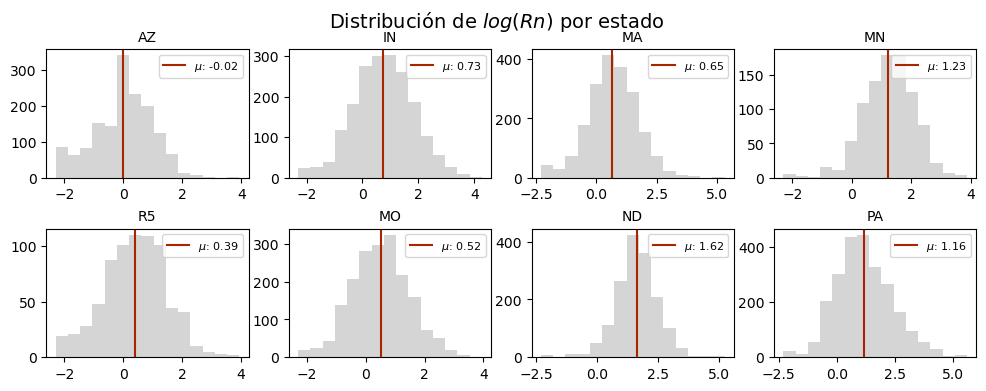

In [8]:
# Especificaciones de figura
fig = plt.figure(figsize=(12,4))
spec = plt.GridSpec(ncols=4, nrows=2, hspace=0.4)

for idx, state in enumerate(radon.state.unique()):
    # Datos
    df_ = (
        radon
        .query(f"state=='{state}'")
        .filter(items=['log_radon']))
    
    # Se agrega figura a panel
    ax = fig.add_subplot(spec[idx])
    
    # Gráfica
    ax.hist(
        x=df_.log_radon
        ,bins=15
        ,color=chart_specs['colors']['grey'])    
    ax.axvline(
        x=df_.log_radon.mean()
        ,color=chart_specs['colors']['red']
        ,label=f'$\mu$: {df_.log_radon.mean():.2f}')
    
    # Anotaciones locales
    ax.set_title(state, fontsize=chart_specs['text'])
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle(r'Distribución de $log(Rn)$ por estado', fontsize=chart_specs['title'])
plt.savefig('../images/radon_p_edo.png')
    
plt.show()

Uranio por estado

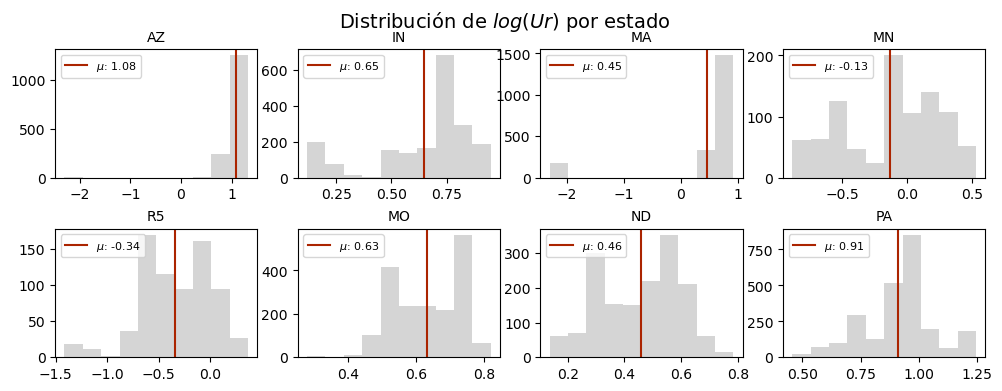

In [9]:
# Especificaciones de figura
fig = plt.figure(figsize=(12,4))
spec = plt.GridSpec(ncols=4, nrows=2, hspace=0.4)

for idx, state in enumerate(radon.state.unique()):
    # Datos
    df_ = (
        radon
        .query(f"state=='{state}'")
        .filter(items=['log_uranium']))
    
    # Se agrega figura a panel
    ax = fig.add_subplot(spec[idx])
    
    # Gráfica
    ax.hist(
        x=df_.log_uranium
        ,bins=10
        ,color=chart_specs['colors']['grey'])    
    ax.axvline(
        x=df_.log_uranium.mean()
        ,color=chart_specs['colors']['red']
        ,label=f'$\mu$: {df_.log_uranium.mean():.2f}')
    
    # Anotaciones locales
    ax.set_title(state, fontsize=chart_specs['text'])
    ax.legend(fontsize=8, loc='upper left')

plt.suptitle(r'Distribución de $log(Ur)$ por estado', fontsize=chart_specs['title'])
plt.savefig('../images/uranio_p_edo.png')
    
plt.show()

Distribución de radón por tipo de suelo

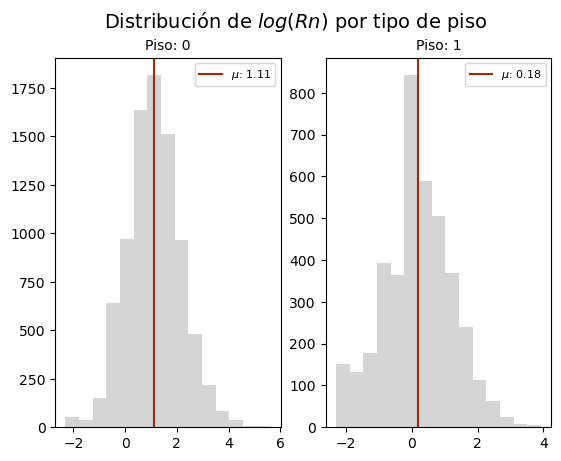

In [10]:
df_ = (
    radon
    .query("floor in [0,1]")
)

# Especificaciones de figura
fig = plt.figure()
spec = plt.GridSpec(ncols=2, nrows=1, hspace=0.4)

for idx, floor in enumerate([0,1]):
    # Datos
    df_ = (
        radon
        .query(f"floor == {floor}")
        .filter(items=['log_radon']))
    
    # Se agrega figura a panel
    ax = fig.add_subplot(spec[idx])
    
    # Gráfica
    ax.hist(
        x=df_.log_radon
        ,bins=15
        ,color=chart_specs['colors']['grey'])    
    ax.axvline(
        x=df_.log_radon.mean()
        ,color=chart_specs['colors']['red']
        ,label=f'$\mu$: {df_.log_radon.mean():.2f}')
    
    # Anotaciones locales
    ax.set_title(f'Piso: {floor}', fontsize=chart_specs['text'])
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle(r'Distribución de $log(Rn)$ por tipo de piso', fontsize=chart_specs['title'])
plt.savefig('../images/dist_radon_p_piso.png')

plt.show()

Distribución de uranio por tipo de suelo

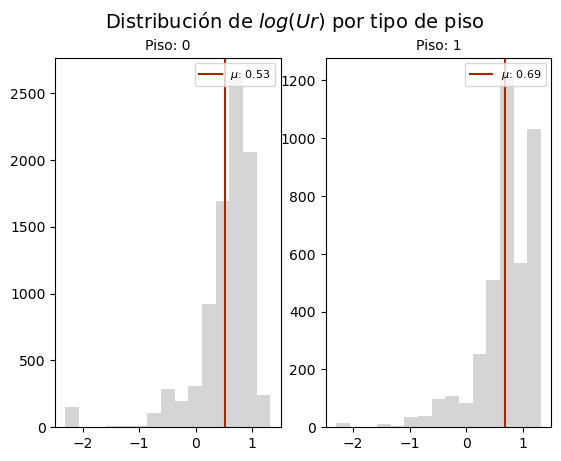

In [11]:
df_ = (
    radon
    .query("floor in [0,1]")
)

# Especificaciones de figura
fig = plt.figure()
spec = plt.GridSpec(ncols=2, nrows=1, hspace=0.4)

for idx, floor in enumerate([0,1]):
    # Datos
    df_ = (
        radon
        .query(f"floor == {floor}")
        .filter(items=['log_uranium']))
    
    # Se agrega figura a panel
    ax = fig.add_subplot(spec[idx])
    
    # Gráfica
    ax.hist(
        x=df_.log_uranium
        ,bins=15
        ,color=chart_specs['colors']['grey'])    
    ax.axvline(
        x=df_.log_uranium.mean()
        ,color=chart_specs['colors']['red']
        ,label=f'$\mu$: {df_.log_uranium.mean():.2f}')
    
    # Anotaciones locales
    ax.set_title(f'Piso: {floor}', fontsize=chart_specs['text'])
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle(r'Distribución de $log(Ur)$ por tipo de piso', fontsize=chart_specs['title'])
plt.savefig('../images/dist_uranio_p_piso.png')

plt.show()

Comportamiento promedio de radón contra uranio

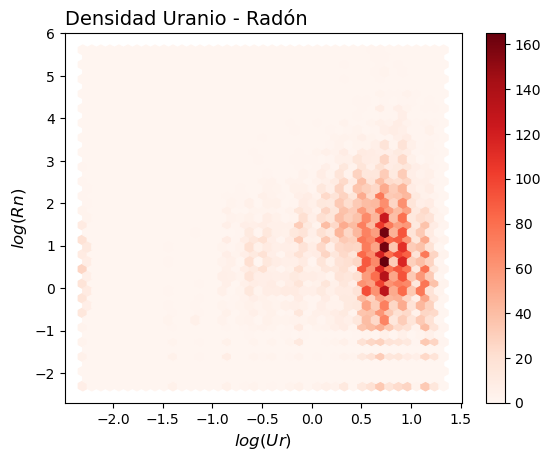

In [12]:
ax = radon.plot.hexbin(
    x='log_uranium'
    ,y='log_radon'
    ,gridsize=40
    ,sharex=False
    ,cmap="Reds"
)

# Anotaciones y estilo
ax.set_title('Densidad Uranio - Radón', fontsize=chart_specs['title'], loc='left')
ax.set_ylabel(r'$log(Rn)$', fontsize=chart_specs['label'])
ax.set_xlabel(r'$log(Ur)$', fontsize=chart_specs['label'])

plt.savefig('../images/densidad_rn_ur.png')

plt.show()

# Replicación de referencia

El análisis inicial se centra exclusivamente en los datos de minesota

In [13]:
# Conjuntos de datos auxiliares
mn_radon = (
    radon
    # Seleccionar datos de Minesota
    .query("state=='MN'")
    # Eliminar columna de estado
    .drop(columns=['state'])
    # Reiniciar índices
    .reset_index(drop=True)
    # Transformación de columnas
    .assign(
        # County como categorías
        county = lambda df_: df_.county.astype('category', copy=False)
        # Índice de county para objetos de stan
        ,county_id = lambda df_: df_.county.cat.codes + 1
    )
)

print(f'number of houses: {len(mn_radon)}')
mn_radon.head()

number of houses: 927


,floor,county,log_radon,log_uranium,county_id
0,1,AITKIN,0.788457,-0.689048,1
1,0,AITKIN,0.788457,-0.689048,1
2,0,AITKIN,1.064711,-0.689048,1
3,0,AITKIN,0.000000,-0.689048,1
4,0,ANOKA,1.131402,-0.847313,2


Información de uranio por condado

In [14]:
mn_counties = (
    mn_radon
    .loc[# Filtro para obtener índices de condado
        mn_radon
        .county
        # Obtener condados únicos
        .drop_duplicates()
        # Extraer ID's de condados únicos
        .index]
    # Reiniciar índices
    .reset_index(drop=True)
    # Asignar recuento de hogares por condado
    .assign(homes = mn_radon.value_counts(subset='county', sort=False).array)
    # Descartar columnas innecesarias
    .drop(columns=['floor', 'log_radon'])
)

print(f'number of counties: {len(mn_counties)}')
mn_counties.head()

number of counties: 85


,county,log_uranium,county_id,homes
0,AITKIN,-0.689048,1,4
1,ANOKA,-0.847313,2,52
2,BECKER,-0.113459,3,3
3,BELTRAMI,-0.593353,4,7
4,BENTON,-0.142890,5,4


**Buena práctica**

Definir la precisión a dos cifras significativas

In [15]:
pd.set_option('display.precision', 2)

## EDA de referencias

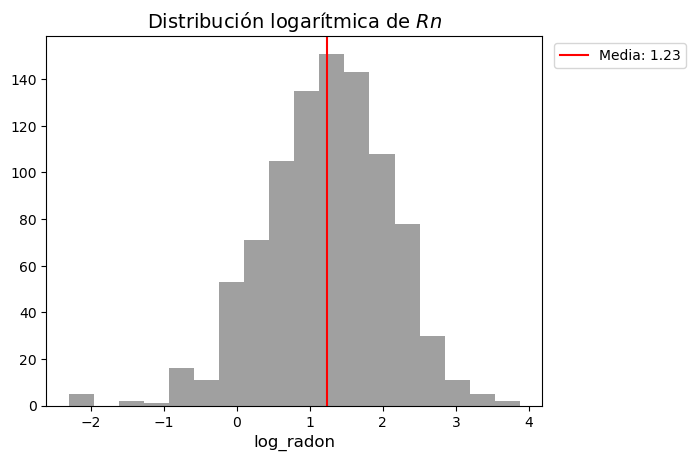

In [16]:
# Especificaciones de figura
fig = plt.figure()
ax = fig.add_subplot()

# Gráficas
ax.hist(
    x=mn_radon.log_radon
    ,bins=18
    ,color='grey'
    ,alpha=0.75)
ax.axvline(
    x=mn_radon.log_radon.mean()
    ,color='red'
    ,label=f'Media: {mn_radon.log_radon.mean():.2f}'
)

# Anotaciones y estilo
ax.set_title(r'Distribución logarítmica de $Rn$', fontsize=chart_specs['title'])
ax.set_xlabel('log_radon', fontsize=chart_specs['label'])
ax.legend(fontsize=chart_specs['text'], bbox_to_anchor=(1.01, 1.0), loc='upper left')

plt.show()

Se quiere hacer inferencia en la variable `log_radon`

In [17]:
target = 'log_radon'

print('---- RESUMEN ESTADÍSTICO: ----')
print(f'Variable: {target}')

mn_radon['log_radon'].describe()

---- RESUMEN ESTADÍSTICO: ----
Variable: log_radon


count    927.00
mean       1.23
std        0.86
min       -2.30
25%        0.64
50%        1.28
75%        1.82
max        3.88
Name: log_radon, dtype: float64

## Relación Radón y nivel del suelo

Se entiende que el radón es un elemento que proviene del subsuelo, por lo tanto, el nivel de piso en el que se realizaron las lecturas debería de ser un buen predictor del nivel de radón observado. El nivel de piso `floor` toma los siguientes valores:

* $0$: Sótano
* $1$: Planta baja

Adicionalmente, hay que destacar que la mayoría de las observaciones se realizaron a nivel de sótano.

In [18]:
mn_radon['floor'].value_counts() / mn_radon.shape[0]

floor
0    0.83
1    0.17
Name: count, dtype: float64

Visualizando el nivel de radón estratificando por el tipo de suelo

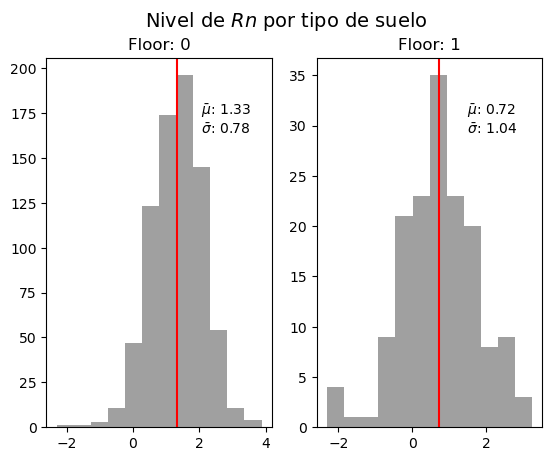

In [19]:
# Distribución de figura
fig = plt.figure()

for figx, idx in enumerate(np.sort(mn_radon['floor'].unique())):
    
    # Agregar axis a layout
    ax_id = f'12{figx+1}'
    ax = fig.add_subplot(int(ax_id))

    # Datos del gráfio
    series_ = mn_radon.query(f"floor=={idx}").log_radon
    # Histograma
    ax.hist(
        x=series_
        ,bins=12
        ,color='grey'
        ,alpha=0.75)
    # Línea de valor central
    ax.axvline(
        x=series_.mean()
        ,color='red')
    # Anotación del valor central
    ax.annotate(
        text=rf'''
        $\bar\mu$: {series_.mean():.2f}
        $\bar\sigma$: {series_.std():.2f}
        '''
        ,xy=(
            series_.mean() - series_.mean()*0.25
            ,ax.get_ylim()[1] - ax.get_ylim()[1]*0.25)
        ,fontsize=chart_specs['text'])
    
    ax.set_title(f'Floor: {idx}', fontsize=chart_specs['label'])

plt.suptitle(r'Nivel de $Rn$ por tipo de suelo'
            ,fontsize=chart_specs['title'])

plt.show()

Lo primero a destacar es la diferencia en la proporción de datos por tipo de suelo. Adicionalmente, se puede observar que el nivel de radón promedio es más bajo en planta baja comparado con sótanos, esto hace sentido debido a que el radón proviene del subsuelo.

Por otro lado, cabe destacar que la desviación típica es mucho más alta para planta baja, lo cual puede ser debido a que se tienen menos datos para este estrato. Lo anterior se traduce en que, para un nivel de confianza del 95%, ambos estratos capturan niveles de radón muy similares, con lo cual la diferencia por el tipo de piso puede no ser tan evidente.

También se puede explorar la dispersión de los datos en cada uno de sus estratos

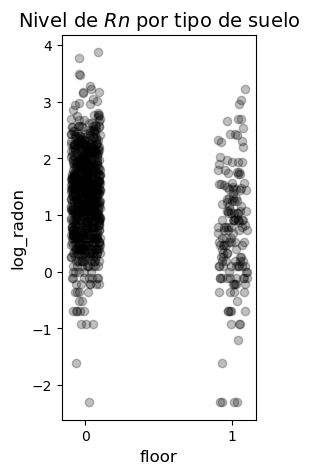

In [20]:
# Especificaciones de figura
fig = plt.figure(figsize=(2.5,5))
ax = fig.add_subplot()

geom_jitter = uniform.rvs(loc=-0.1, scale=0.2, size=mn_radon.shape[0])

# Gráfica
ax.scatter(
    x=mn_radon['floor'] + geom_jitter
    ,y=mn_radon['log_radon']
    ,color='black'
    ,alpha=0.25)

# Anotaciones y estilo
ax.set_xticks(ticks=mn_radon['floor'].unique())
ax.set_title(r'Nivel de $Rn$ por tipo de suelo', fontsize=chart_specs['title'])
ax.set_xlabel('floor', fontsize=chart_specs['label'])
ax.set_ylabel('log_radon', fontsize=chart_specs['label'])

plt.show()

## Información a nivel de condado

Debido a que la mayoría de los registros se realizaron a nivel de sótano, y debido a que la mayoría de los condados tienen relativamente pocos registros, hay varios condados que solamente tienen registros a nivel sótano

In [21]:
print("Número total de condados:", end=' ')
print(
    mn_radon
    .county
    .nunique()
)

print("Condados con registros en sótano:", end=' ')
print(
    mn_radon
    .loc[mn_radon['floor'] == 0]
    .county
    .nunique()
)

print("Condados con registros en planta:", end=' ')
print(
    mn_radon
    .loc[mn_radon['floor'] == 1]
    .county
    .nunique()
)

Número total de condados: 85
Condados con registros en sótano: 85
Condados con registros en planta: 60


También podemos explorar el número de casas por condado

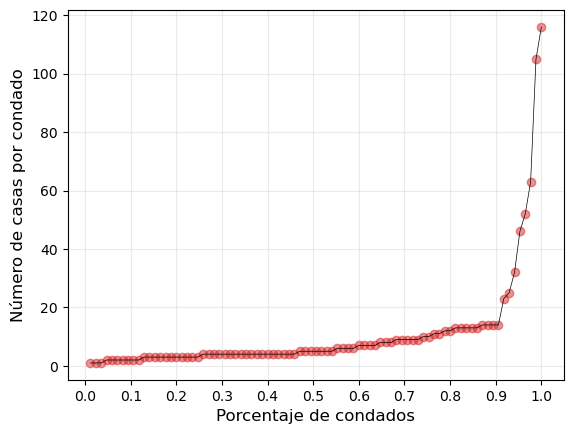

In [22]:
# Datos de la figura
df_ = (
    mn_counties
    .filter(items=['county','homes'])
    .sort_values(by='homes')
    .assign(
        orden = np.arange(start=1, stop=mn_counties.shape[0]+1, step=1)
        ,frec = lambda df_: df_.orden / df_.orden.max())
)

# Configuraciones de figura
fig = plt.figure()
ax = fig.add_subplot()

# Contenido de figura
# Dispersión de puntos
ax.scatter(
    x=df_.frec
    ,y=df_.homes
    ,color='tab:red'
    ,alpha=0.5)
# Líneas de conexión
ax.plot(
    df_.frec
    ,df_.homes
    ,color='black'
    ,linewidth=0.5)

# Anotaciones y estilo
ax.set_ylabel('Número de casas por condado', fontsize=chart_specs['label'])
ax.set_xlabel('Porcentaje de condados', fontsize=chart_specs['label'])
ax.set_xticks(ticks=np.arange(0,1.1,0.1))
ax.grid(alpha=0.25)

plt.show()

Podemos ver que cerca del 90% de los condados cuentan con menos de 20 casas registradas en los datos. Esto provoca que a nivel de condado, se tenga una distribución con una cola larga a la derecha.

Hay que tomar en cuenta que la cantidad de datos por condado impacta directamente en la precisión de las estimaciones que pudieran hacerse.

Otra forma de ver la dispersión de los datos por condado es la siguiente:

In [23]:
def ordenar_tendencia_central(df, agrupadora, ordenadora, mo='mean'):
    """
    Parámetros
    ----------
    df: dataframe_lile
        DataFrame que contiene al menos una variable agrupadora y
        una variable ordenadora
    agrupadora: str_like
        Nombre de la variable en df por la cual se quiere agrupar
    ordenadora: str_like
        Nombre de la variable en df por la cual se quiere ordenar
    mo: medida de ordenamiento, default='mean'
        Métrica por la cual se quiere ordenar df
        Valores que puede tomar: {'mean','median','std','count'}
    """
    #Medidas de ordenamiento
    MO = {'mean': df[[agrupadora,ordenadora]].groupby(by=agrupadora).mean(),
         'median': df[[agrupadora,ordenadora]].groupby(by=agrupadora).median(),
         'std': df[[agrupadora,ordenadora]].groupby(by=agrupadora).std(),
         'count': df[[agrupadora,ordenadora]].groupby(by=agrupadora).count()}
    
    #Listado con ordenamiento
    L = MO[mo].sort_values(by=ordenadora).index.to_list()

    #Se determina a esa variable como un índice categórico
    df[agrupadora] = pd.CategoricalIndex(df[agrupadora], ordered=True, categories=L)

    #Se ordena el dataset con los valores de L
    df = df.sort_values(ordenadora)
    
    return df

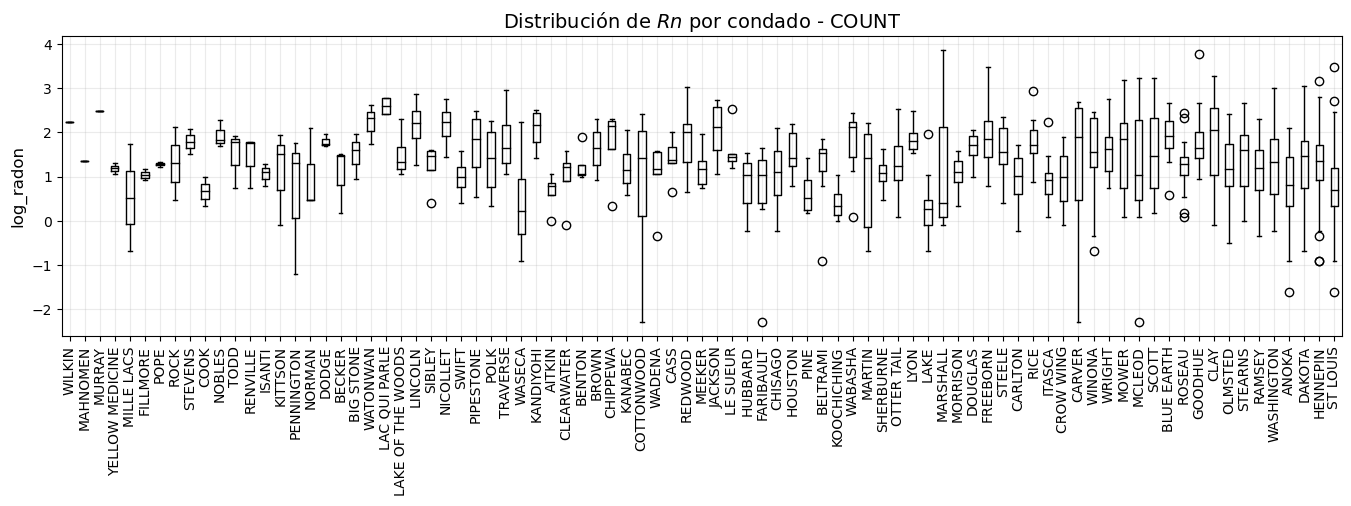

In [24]:
# Datos de la figura
df_ = mn_radon.copy()
mo = 'count'
ordenar_tendencia_central(df_, 'county', 'log_radon', mo)

# Configuraciones de figura
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot()

# Gráfica con objetos de pandas
(
    df_
    .boxplot(
        column='log_radon'
        ,by='county'
        ,color='black'
        ,ax=ax)
)

# Anotaciones y estilo
ax.set_title(rf'Distribución de $Rn$ por condado - {mo.upper()}', fontsize=chart_specs['title'])
ax.set_ylabel('log_radon', fontsize=chart_specs['label'])
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(alpha=0.25)

plt.suptitle('')
plt.show()

## Nivel de Rn contra Uranio en el suelo

Se cuenta con información de los niveles de Uranio, pero a diferencia del Radón, esta información se encuentra a nivel de condado

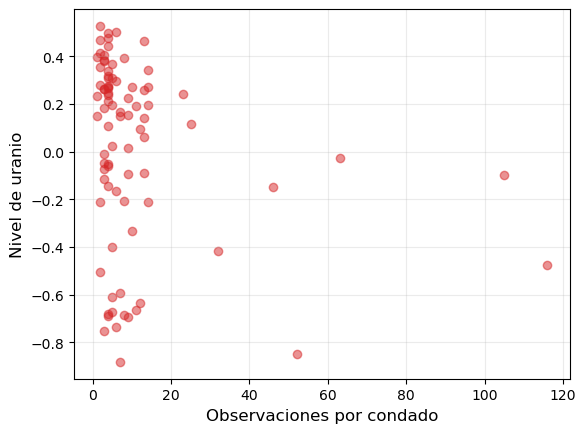

In [25]:
# Especificaciones de figura
fig = plt.figure()
ax = fig.add_subplot()

# Contenido de figura
ax.scatter(
    x=mn_counties.homes
    ,y=mn_counties.log_uranium
    ,color='tab:red'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_xlabel('Observaciones por condado', fontsize=chart_specs['label'])
ax.set_ylabel('Nivel de uranio', fontsize=chart_specs['label'])
ax.grid(alpha=0.25)

plt.show()

Observamos el comportamiento del radón contra el comportamiento de uranio, estratificando por el tipo de piso, es decir, si fue en sótano a en planta baja

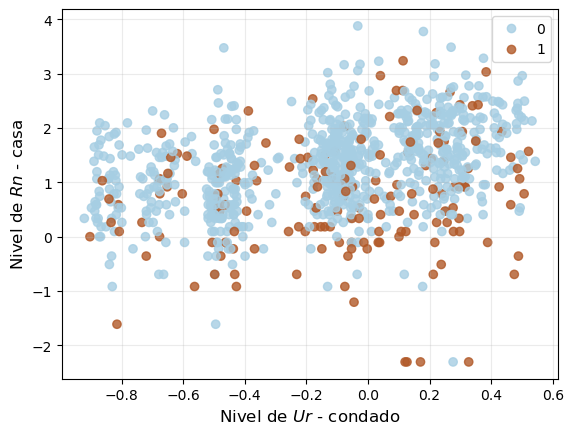

In [26]:
# Configuraciones de figura
fig = plt.figure()
ax = fig.add_subplot()

geom_jitter = uniform.rvs(loc=-0.05, scale=0.1, size=mn_radon.shape[0])

# Contenido de figura
scatter = ax.scatter(
    x=mn_radon.log_uranium + geom_jitter
    ,y=mn_radon.log_radon
    ,c=mn_radon.floor
    ,cmap='Paired'
    ,alpha=0.8)

# Anotaciones y estilo
ax.set_xlabel(r'Nivel de $Ur$ - condado', fontsize=chart_specs['label'])
ax.set_ylabel(r'Nivel de $Rn$ - casa', fontsize=chart_specs['label'])
ax.legend(handles=scatter.legend_elements()[0], labels=['0','1'])
ax.grid(alpha=0.25)

plt.show()

---